Simple PyTorch Neural Network on "train.csv" Dataset

This notebook will load the dataset "train.csv", preprocess the data, and train a simple PyTorch neural network on the dataset.

The goal was mainly to understand what didn't work in the quantization of the autogluon model. We decided to traina simple pytorch model and test quantization and qat to test that quantization works properly.


Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score


Load and preprocess the dataset

In [2]:
# Load the dataset
data = pd.read_csv('./datasets/CICIDS2017/balanced_binary/train.csv')

# Display the first few rows of the dataset
data.head()


,ID,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,521918,0.000809,2.816666e-06,0.000005,0.000007,0.000007,3.142864e-07,0.001813,0.019355,0.007575,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1002403,0.001221,1.416667e-07,0.000005,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1052395,0.076356,2.250000e-07,0.000000,0.000003,0.000000,9.153974e-09,0.000000,0.000000,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1032054,0.001221,2.405916e-04,0.000009,0.000014,0.000002,1.769921e-05,0.000806,0.000000,0.001459,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,869943,0.001221,4.679666e-04,0.000009,0.000017,0.000002,1.770836e-05,0.000806,0.000000,0.001459,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Data preprocessing


In [3]:
# Drop the ID column
data = data.drop(columns=['ID'])

# Separate features and labels
X = data.drop(columns=['Label'])
y = data['Label']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


Defininig the neural network model


In [4]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
num_classes = len(np.unique(y))

model = SimpleNN(input_size, num_classes)


Training

In [5]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 20
batch_size = 64

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.0546
Epoch [2/20], Loss: 0.1482
Epoch [3/20], Loss: 0.0364
Epoch [4/20], Loss: 0.0194
Epoch [5/20], Loss: 0.0559
Epoch [6/20], Loss: 0.0790
Epoch [7/20], Loss: 0.0086
Epoch [8/20], Loss: 0.0209
Epoch [9/20], Loss: 0.0433
Epoch [10/20], Loss: 0.0508
Epoch [11/20], Loss: 0.0777
Epoch [12/20], Loss: 0.0173
Epoch [13/20], Loss: 0.0573
Epoch [14/20], Loss: 0.0219
Epoch [15/20], Loss: 0.0753
Epoch [16/20], Loss: 0.0080
Epoch [17/20], Loss: 0.0124
Epoch [18/20], Loss: 0.0192
Epoch [19/20], Loss: 0.0309
Epoch [20/20], Loss: 0.0236


Evaluate and save the model

In [6]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Accuracy on the test set: {accuracy:.4f}')
torch.save(model.state_dict(), 'simple_nn.pth')
print('Model saved as simple_nn.pth')


Accuracy on the test set: 0.9863
Model saved as simple_nn.pth


Apply dynamic quantization and evaluate

In [12]:
import torch.quantization as quant
# Set the quantized engine
torch.backends.quantized.engine = 'qnnpack' if torch.backends.quantized.engine == 'none' else torch.backends.quantized.engine

# Apply dynamic quantization
quantized_model = quant.quantize_dynamic(
    model, {nn.Linear}, dtype=torch.qint8
)

# Evaluate the quantized model on the test set
quantized_model.eval()
with torch.no_grad():
    outputs = quantized_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    quantized_accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Accuracy on the test set after quantization: {quantized_accuracy:.4f}')


Accuracy on the test set after quantization: 0.5673


Because the results of the quantization were bad, I will follow some steps to improve it

1. Ensuring the preprocessing steps are correctly implemented and appropriate for the model

In [13]:
# Recheck Preprocessing
print("Data Preprocessing Steps:")

# Check for missing values
missing_values = data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

# Check the data types
data_types = data.dtypes
print(f"Data types of each column:\n{data_types}")

# Ensure the data is standardized properly
print(f"Means of each feature (should be close to 0):\n{X_train_tensor.mean(dim=0)}")
print(f"Standard deviations of each feature (should be close to 1):\n{X_train_tensor.std(dim=0)}")


Data Preprocessing Steps:
Missing values in each column:
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 62, dtype: int64
Data types of each column:
Destination Port               float64
Flow Duration                  float64
Total Fwd Packets              float64
Total Backward Packets         float64
Total Length of Fwd Packets    float64
                                ...   
Idle Mean                      float64
Idle Std                       float64
Idle Max                       float64
Idle Min                       float64
Label                            int64
Length: 62, dtype: object
Means of each feature (should be close to 0):
tensor([-1.3219e-08,  2.447

2. Revisiting the model architecture to ensure it is suitable for quantization and Redefining and Training the Model with Improved Architecture

In [14]:
# Define an improved neural network model
class ImprovedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
num_classes = len(np.unique(y))

improved_model = ImprovedNN(input_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

# Training the improved model
num_epochs = 20
batch_size = 64

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        # Forward pass
        outputs = improved_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.0599
Epoch [2/20], Loss: 0.1105
Epoch [3/20], Loss: 0.0191
Epoch [4/20], Loss: 0.0246
Epoch [5/20], Loss: 0.0541
Epoch [6/20], Loss: 0.0036
Epoch [7/20], Loss: 0.0388
Epoch [8/20], Loss: 0.0142
Epoch [9/20], Loss: 0.0069
Epoch [10/20], Loss: 0.0410
Epoch [11/20], Loss: 0.0514
Epoch [12/20], Loss: 0.0696
Epoch [13/20], Loss: 0.0613
Epoch [14/20], Loss: 0.1696
Epoch [15/20], Loss: 0.0044
Epoch [16/20], Loss: 0.0060
Epoch [17/20], Loss: 0.0192
Epoch [18/20], Loss: 0.0457
Epoch [19/20], Loss: 0.0193
Epoch [20/20], Loss: 0.0128


Evaluate the improved model

In [21]:
# Evaluate the improved model on the test set
improved_model.eval()
with torch.no_grad():
    outputs = improved_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    improved_accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Accuracy on the test set (Improved Model): {improved_accuracy:.4f}')


Accuracy on the test set (Improved Model): 0.9897


Apply dynamic quantization to the improved model and evaluate

In [16]:
# Set the quantized engine
torch.backends.quantized.engine = 'qnnpack' if torch.backends.quantized.engine == 'none' else torch.backends.quantized.engine

# Ensure the improved model is in evaluation mode before quantizing
improved_model.eval()

# Apply dynamic quantization to the improved model
quantized_improved_model = quant.quantize_dynamic(
    improved_model, {nn.Linear}, dtype=torch.qint8
)

# Ensure the quantized improved model is in evaluation mode
quantized_improved_model.eval()

# Evaluate the quantized improved model on the test set
with torch.no_grad():
    outputs = quantized_improved_model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    quantized_improved_accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Accuracy on the test set after quantization (Improved Model): {quantized_improved_accuracy:.4f}')
    


Accuracy on the test set after quantization (Improved Model): 0.5885


Comparing the results

In [17]:
print(f'Accuracy on the test set (Original Model): {accuracy:.4f}')
print(f'Accuracy on the test set (Improved Model): {improved_accuracy:.4f}')
print(f'Accuracy on the test set after quantization (Improved Model): {quantized_improved_accuracy:.4f}')


Accuracy on the test set (Original Model): 0.9863
Accuracy on the test set (Improved Model): 0.9897
Accuracy on the test set after quantization (Improved Model): 0.5885


3. Integrate quantization into the training process for potentially better results, using Quantization-Aware Training

In [22]:
from torch.quantization import QuantStub, DeQuantStub

class QuantAwareNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(QuantAwareNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
    
    def forward(self, x):
        x = self.quant(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x

# Initialize the model
quant_aware_model = QuantAwareNN(input_size, num_classes)

# Prepare for quantization-aware training
quant_aware_model.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
torch.quantization.prepare_qat(quant_aware_model, inplace=True)

# Fine-tune the model with quantization-aware training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(quant_aware_model.parameters(), lr=0.001)

num_epochs = 20
batch_size = 64

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train_tensor.size()[0])
    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        # Forward pass
        outputs = quant_aware_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Convert to quantized model
quantized_model_qat = torch.quantization.convert(quant_aware_model.eval(), inplace=False)

# Evaluate the quantized model on the test set
with torch.no_grad():
    outputs = quantized_model_qat(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    quantized_qat_accuracy = accuracy_score(y_test_tensor, predicted)
    print(f'Accuracy on the test set after quantization-aware training: {quantized_qat_accuracy:.4f}')


Epoch [1/20], Loss: 0.0456
Epoch [2/20], Loss: 0.0119
Epoch [3/20], Loss: 0.0334
Epoch [4/20], Loss: 0.0680
Epoch [5/20], Loss: 0.0347
Epoch [6/20], Loss: 0.0154
Epoch [7/20], Loss: 0.0105
Epoch [8/20], Loss: 0.1116
Epoch [9/20], Loss: 0.1383
Epoch [10/20], Loss: 0.0114
Epoch [11/20], Loss: 0.0223
Epoch [12/20], Loss: 0.1291
Epoch [13/20], Loss: 0.0182
Epoch [14/20], Loss: 0.0229
Epoch [15/20], Loss: 0.0468
Epoch [16/20], Loss: 0.0318
Epoch [17/20], Loss: 0.0142
Epoch [18/20], Loss: 0.1159
Epoch [19/20], Loss: 0.1244
Epoch [20/20], Loss: 0.0498
Accuracy on the test set after quantization-aware training: 0.9816


Compare the results

In [23]:
print(f'Accuracy on the test set (Original Model): {accuracy:.4f}')
print(f'Accuracy on the test set after quantization (Original Model): {quantized_accuracy:.4f}')
print(f'Accuracy on the test set (Improved Model): {improved_accuracy:.4f}')
print(f'Accuracy on the test set after quantization (Improved Model): {quantized_improved_accuracy:.4f}')
print(f'Accuracy on the test set after quantization-aware training: {quantized_qat_accuracy:.4f}')


Accuracy on the test set (Original Model): 0.9863
Accuracy on the test set after quantization (Original Model): 0.5673
Accuracy on the test set (Improved Model): 0.9897
Accuracy on the test set after quantization (Improved Model): 0.5885
Accuracy on the test set after quantization-aware training: 0.9816


Plot results

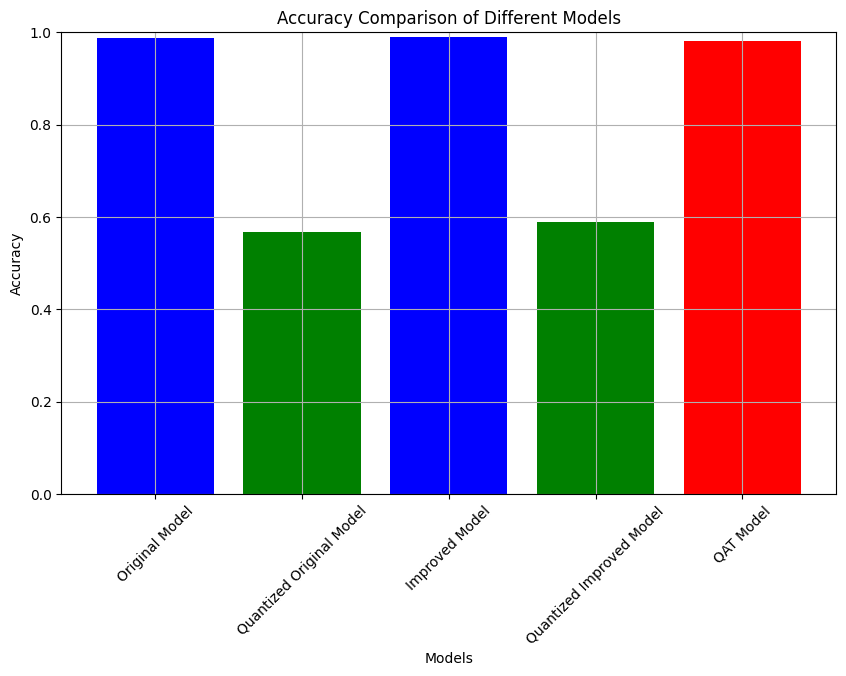

In [24]:
import matplotlib.pyplot as plt
# Prepare data for plotting
models = ['Original Model', 'Quantized Original Model', 'Improved Model', 'Quantized Improved Model', 'QAT Model']
accuracies = [accuracy, quantized_accuracy, improved_accuracy, quantized_improved_accuracy, quantized_qat_accuracy]

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
